# Evalutation of the v7_base model

extract the emittances for all offsets and safe in a csv

In [1]:
import os
import numpy as np
import pandas as pd
import altair as alt
alt.enable_mime_rendering()
import scipy.constants

import PhaseSpaceEval.monitor_quantities as monq
from PhaseSpaceEval.import_particle_data import *
from PhaseSpaceEval.trajectory import Trajectory
from PhaseSpaceEval.particlemonitor import ParticleMonitor

## Import Raw Data and set filename *!!! ADJUST FILENAMES HERE !!!*

In [2]:
MODELNAME = "v7_base"
RAW_PATH = "rawdata_" + MODELNAME + "/"
EMIT_FILENAME = "emit_" + MODELNAME + ".csv" # Name for the emittance output file
MON_FILENAME = "mon_" + MODELNAME + ".csv" # Name for the monitors output file

particle_source_names = import_source_names(RAW_PATH + MODELNAME + "-source_names.txt")
particle_constants = import_particle_constants(RAW_PATH + MODELNAME + "-constants.txt")
particle_trajectories = import_particle_trajectories(RAW_PATH + MODELNAME + "-trajectories.txt")

## Create convenient lists
### Raw Data

In [3]:
# Delete the single_centre source, not required
for key in particle_source_names.keys():
    if particle_source_names[key] == "single_centre":
        del(particle_source_names[key])
        break
        
# Generate simple list with all source IDs
sourceIDs = list(particle_source_names.keys())
#print(sourceIDs)

# Create lists with all particles belonging to a source and with the id of the central particles
particlesBySrc = dict() # dict for all particleIDs
centresBySrc = dict() # dict with the ids of the central particles
for sID in sourceIDs:
    pIDs = particle_constants["particleID"].loc[particle_constants["sourceID"] == sID].tolist()
    particlesBySrc.update({sID : pIDs})
    centresBySrc.update({sID : min(pIDs)}) # the smallest pID for each source is the centre
#print(particlesBySrc)
#print(centresBySrc)

### Trajectories

In [4]:
# Create Trajectories
trajsBySrc = dict() # Dict for all trajectories
ctrajsBySrc = dict() # Dict for central trajectories
lostParticles = list()
for sID in sourceIDs:
    # Compute central trajectory for each sID
    cID = centresBySrc[sID]
    ctr = Trajectory(particle_trajectories[cID],
                     particle_constants.loc[particle_constants["particleID"] == cID].squeeze())
    ctrajsBySrc.update({sID : ctr})

    # For each sID compute the trajectories of all pIDs
    # Note Particles that cannot be found in trajectory dataframe, these were lost
    pIDs = particlesBySrc[sID]
    trajs = list()
    for pID in pIDs:
        try:
            tr = Trajectory(particle_trajectories[pID],
                            particle_constants.loc[particle_constants["particleID"] == pID].squeeze())
        except KeyError:
            lostParticles.append(pID)
        trajs.append(tr)
    trajsBySrc.update({sID : trajs})
print(lostParticles)

[11838]


### Monitors

In [5]:
# Create Monitors
monBySrc = dict()
for sID in sourceIDs:
    ctr = ctrajsBySrc[sID]
    t0 = ctr.find_time("z", 770)
    mon = ParticleMonitor(time0=t0, trajectory=ctr)
    monBySrc.update({sID : mon})

## Record Monitor Interactions

In [6]:
# Record Monitor Interactions
for sID in sourceIDs:
    mon = monBySrc[sID]
    mon.reset_events()
    mon.reset_misses()
    for tr in trajsBySrc[sID]:
        mon.record_intersect(tr)

# Read Out misses and events
missesBySrc = dict()
eventsBySrc = dict()
for sID in sourceIDs:
    missesBySrc.update({sID : monBySrc[sID].get_misses()})
    eventsBySrc.update({sID : monBySrc[sID].get_events()})
#print(missesBySrc)

# Add lost particles to miss counter
for pID in lostParticles:
    for sID in sourceIDs:
        if pID in particlesBySrc[sID]:
            missesBySrc[sID] += 1
#print(missesBySrc)

## Export Monitor Interactions

In [7]:
export_events = pd.DataFrame()
for sID in sourceIDs:
    events = eventsBySrc[sID].copy()
    events["sourceID"] = sID
    events["sourceName"] = particle_source_names[sID]
    export_events = export_events.append(events, ignore_index=True)
export_events.to_csv(MON_FILENAME)

## Compute and save emittances

In [8]:
# Compute and save emittances
colnames = ["sourceID", "sourceName", "x_offset", "y_offset", "x_emittance", "y_emittance",
            "x_norm_emittance", "y_norm_emittance", "losses", "relbeta"]
emit_df = pd.DataFrame(columns=colnames)
emit_temp = pd.DataFrame([np.zeros(len(colnames))], columns=colnames)
for sID in sourceIDs:
    name = particle_source_names[sID]
    xoff = float(name.split('_')[1])
    yoff = float(name.split('_')[3])
    xemit = monq.emittance_u(eventsBySrc[sID])
    yemit = monq.emittance_v(eventsBySrc[sID])
    # Compute rel. beta for the screen 1e6 mm/ns ->m/s
    beta = monBySrc[sID].abs_vel / scipy.constants.speed_of_light * 1e6
    xemit_n = beta * (1 - beta**2)**(-0.5) * xemit # beta * gamme * emit
    yemit_n = beta * (1 - beta**2)**(-0.5) * yemit
    losses = missesBySrc[sID]
    
    emit_temp["sourceID"] = sID
    emit_temp["sourceName"] = name
    emit_temp["x_offset"] = xoff
    emit_temp["y_offset"] = yoff
    emit_temp["x_emittance"] = xemit
    emit_temp["y_emittance"] = yemit
    emit_temp["x_norm_emittance"] = xemit_n
    emit_temp["y_norm_emittance"] = yemit_n
    emit_temp["losses"] = losses
    emit_temp["relbeta"] = beta

    emit_df = emit_df.append(emit_temp, ignore_index=True)

emit_df.sort_values(["x_offset", "y_offset"], inplace=True)
emit_df.reset_index(inplace=True, drop=True)

# Load emittance data from startinplane to compute relative emittance growth
emit_start = pd.read_csv("emit_startingplane.csv", index_col=0)
emit_df["x_emittance_rel"] = emit_df["x_emittance"]/emit_start["x_emittance"]
emit_df["y_emittance_rel"] = emit_df["y_emittance"]/emit_start["y_emittance"]
# Save emittance table
emit_df.to_csv(EMIT_FILENAME)
# Show head for debugging purposes
emit_df.head()

,sourceID,sourceName,x_offset,y_offset,x_emittance,y_emittance,x_norm_emittance,y_norm_emittance,losses,relbeta,x_emittance_rel,y_emittance_rel
0,16777222,x_-15_y_0,-15.0,0.0,1.655953,1.571351,0.003823,0.003627,0,0.002308,1.021478,0.999424
1,16777229,x_-15_y_5,-15.0,5.0,1.623696,1.597929,0.003748,0.003689,0,0.002308,1.019223,1.002666
2,16777236,x_-15_y_10,-15.0,10.0,1.650815,1.606972,0.003811,0.003710,0,0.002308,1.020841,1.006443
3,16777243,x_-15_y_15,-15.0,15.0,1.737257,1.664539,0.004010,0.003842,0,0.002308,1.039537,1.001601
4,16777220,x_-10_y_0,-10.0,0.0,1.594414,1.552032,0.003681,0.003583,0,0.002308,1.001436,0.999630


## Plots

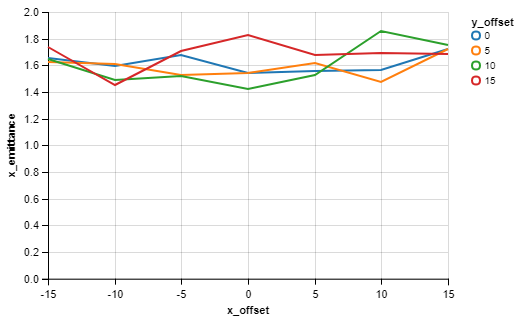

In [9]:
alt.Chart(emit_df).mark_line().encode(
    color='y_offset:N',
    x='x_offset',
    y='x_emittance',
)

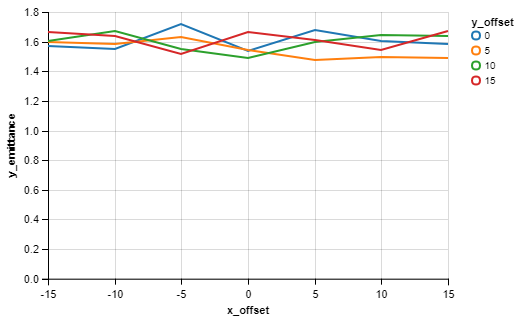

In [10]:
alt.Chart(emit_df).mark_line().encode(
    color='y_offset:N',
    x='x_offset',
    y='y_emittance',
)

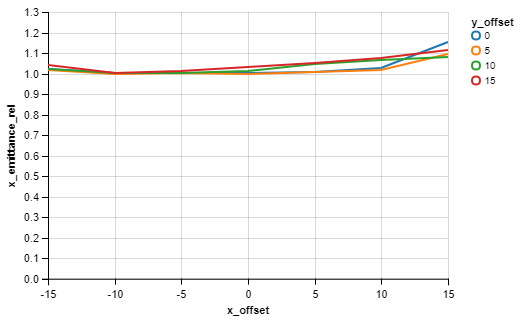

In [11]:
alt.Chart(emit_df).mark_line().encode(
    color='y_offset:N',
    x='x_offset',
    y='x_emittance_rel',
)

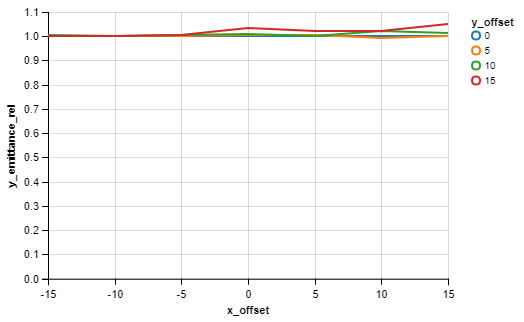

In [12]:
alt.Chart(emit_df).mark_line().encode(
    color='y_offset:N',
    x='x_offset',
    y='y_emittance_rel',
)

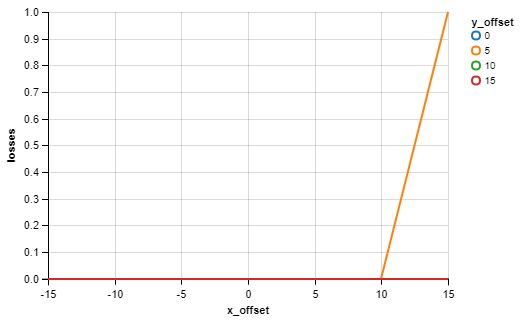

In [13]:
alt.Chart(emit_df).mark_line().encode(
    color='y_offset:N',
    x='x_offset',
    y='losses',
)